# Linear Regression with Snowpark & LocalStack

An E-Commerce company aims to apply machine learning for understanding customer engagement with its digital platforms (website and app). The goal is to determine whether to prioritize improving the mobile app or website. Using a Linear Regression model, we will assess the impact of user activity on the likelihood of increased spending.

In this notebook, we will explore how you can use LocalStack's Snowflake emulator extension, to develop and test your Snowflake data pipelines entirely on your local machine! In this notebook, we will showcase how you can use LocalStack's Snowflake with Snowpark for Python and your favorite Python libraries for data analysis and machine learning.

## Step 1: Start LocalStack

The essential prerequisites for running this notebook include:

- LocalStack CLI with a `LOCALSTACK_AUTH_TOKEN`
- LocalStack Snowflake
- Snowpark with other Python libraries

Start your LocalStack container in your preferred terminal/shell.

In [4]:
!localstack status

┌─────────────────┬───────────────────────────────────────────────────────┐
│ Runtime version │ 3.1.1.dev                                             │
│ Docker image    │ tag: latest, id: e54cdb22ef6d, 📆 2024-02-01T21:12:55 │
│ Runtime status  │ ✔ running (name: "localstack-main", IP: 172.17.0.2)   │
└─────────────────┴───────────────────────────────────────────────────────┘
⠹ Querying Docker status


## Step 2: Import libraries and configure LocalStack Snowflake

You can now import the required libraries and configure LocalStack's Snowflake. LocalStack Snowflake emulator runs on `snowflake.localhost.localstack.cloud`. You can use the Snowpark to connect to the locally running Snowflake server.


In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from snowflake.snowpark import functions as F
from snowflake.snowpark.functions import pandas_udf
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import *
from snowflake.snowpark.version import VERSION

%matplotlib inline

In [2]:
USERNAME = 'test'
PASSWORD = 'test'
SF_ACCOUNT = 'test'
SF_WH = 'test'
SF_DB = 'test'
SF_SCHEMA = 'test'

CONNECTION_PARAMETERS = {
   "account": SF_ACCOUNT,
   "user": USERNAME,
   "password": PASSWORD,
   "database": SF_DB,
   "schema": SF_SCHEMA,
   "warehouse": SF_WH,
   "host": "snowflake.localhost.localstack.cloud"
}
session = Session.builder.configs(CONNECTION_PARAMETERS).create()

In [3]:
snowpark_version = VERSION
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Role                        : {}'.format(session.get_current_role()))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

Database                    : "test"
Schema                      : "test"
Warehouse                   : "test"
Role                        : "PUBLIC"
Snowpark for Python version : 1.11.1


## Step 3: Load the Data

The data is located in the `EcommerceCustomers.csv` file. Import it using Pandas and further create a Snowpark DF from the Pandas DF. You can further load the customer data from Snowpark DF to a Snowflake internal table, and create a Pandas data frame from the Snowflake table.

In [5]:
customers = pd.read_csv("EcommerceCustomers.csv")
customers.head()

,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092


In [6]:
snowdf = session.write_pandas(customers,"CUSTOMERS",auto_create_table='True')

In [7]:
snowdf.write.mode("overwrite").saveAsTable("customers_new") 

session.table("CUSTOMERS_NEW").limit(3).show(5)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EMAIL"                    |"ADDRESS"                       |"AVATAR"   |"AVG. SESSION LENGTH"  |"TIME ON APP"       |"TIME ON WEBSITE"   |"LENGTH OF MEMBERSHIP"  |"YEARLY AMOUNT SPENT"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|mstephenson@fernandez.com  |835 Frank Tunnel                |Violet     |34.49726772511229      |12.655651149166752  |39.57766801952616   |4.082620632952961       |587.9510539684005      |
|                           |Wrightmouth, MI 82180-9605      |           |                       |                    |                    |                        |                       |
|hduke@hotmail.com          |4547 Archer Common   

In [8]:
custdf = session.table('CUSTOMERS_NEW').toPandas() 

print(f"'custdf' local dataframe created. Number of records: {len(custdf)} ")

'custdf' local dataframe created. Number of records: 500 


In [10]:
custdf

,EMAIL,ADDRESS,AVATAR,AVG. SESSION LENGTH,TIME ON APP,TIME ON WEBSITE,LENGTH OF MEMBERSHIP,YEARLY AMOUNT SPENT
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092
...,...,...,...,...,...,...,...,...
495,lewisjessica@craig-evans.com,"4483 Jones Motorway Suite 872\nLake Jamiefurt,...",Tan,33.237660,13.566160,36.417985,3.746573,573.847438
496,katrina56@gmail.com,"172 Owen Divide Suite 497\nWest Richard, CA 19320",PaleVioletRed,34.702529,11.695736,37.190268,3.576526,529.049004
497,dale88@hotmail.com,"0787 Andrews Ranch Apt. 633\nSouth Chadburgh, ...",Cornsilk,32.646777,11.499409,38.332576,4.958264,551.620145
498,cwilson@hotmail.com,"680 Jennifer Lodge Apt. 808\nBrendachester, TX...",Teal,33.322501,12.391423,36.840086,2.336485,456.469510


## Step 4: Model Training & Testing

In this step, we will:

- Understand the correlation matrix for the new data frame
- Define X and Y for modeling
- Split into training & Testing datasets
- Create an instance of Linear Regression and Fit the training datasets

/var/folders/k6/121xsv7x68vb97ptv8008zpr0000gn/T/ipykernel_2974/1851941364.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(custdf.corr(), vmin=-1, vmax=1, annot=True, cmap='Spectral')


<Axes: title={'center': 'Encoded Correlation Heatmap for Used Vehicles Dataset'}>

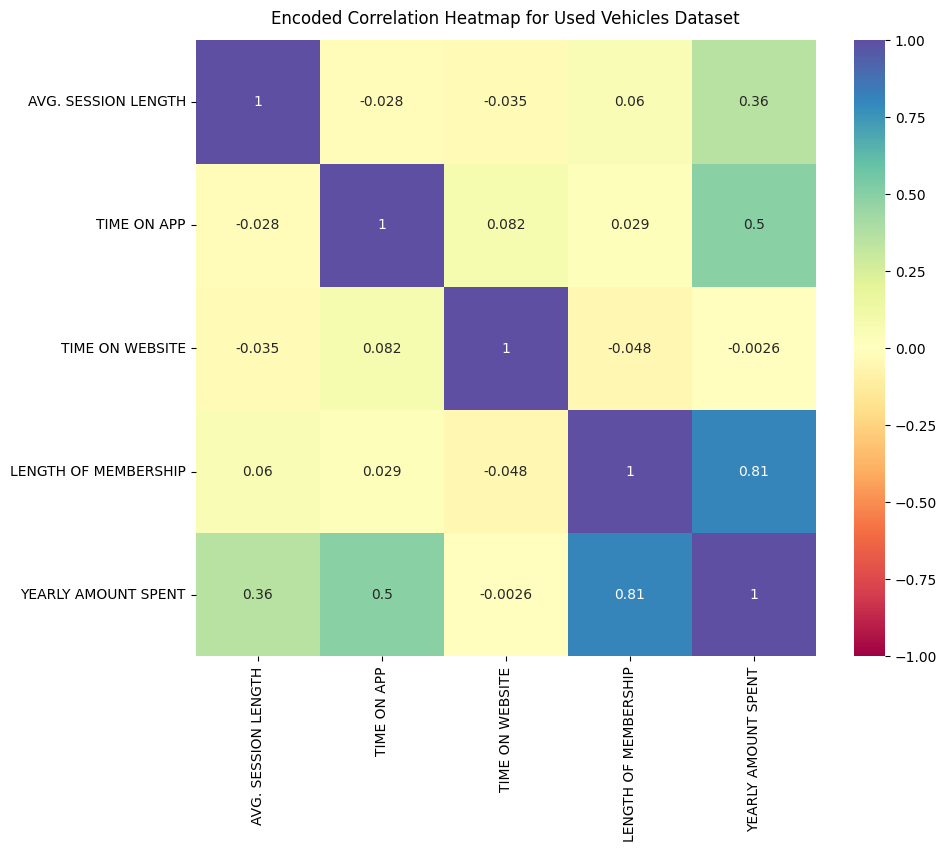

In [9]:
f, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Encoded Correlation Heatmap for Used Vehicles Dataset', pad=12)
sns.heatmap(custdf.corr(), vmin=-1, vmax=1, annot=True, cmap='Spectral')

In [11]:
X = custdf[['AVG. SESSION LENGTH', 'TIME ON APP',
       'TIME ON WEBSITE', 'LENGTH OF MEMBERSHIP']]
Y = custdf['YEARLY AMOUNT SPENT']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                 test_size=0.3, random_state=101)

In [13]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [15]:
predictions = lm.predict(X_test)
predictions

array([456.44186104, 402.72005312, 409.2531539 , 591.4310343 ,
       590.01437275, 548.82396607, 577.59737969, 715.44428115,
       473.7893446 , 545.9211364 , 337.8580314 , 500.38506697,
       552.93478041, 409.6038964 , 765.52590754, 545.83973731,
       693.25969124, 507.32416226, 573.10533175, 573.2076631 ,
       397.44989709, 555.0985107 , 458.19868141, 482.66899911,
       559.2655959 , 413.00946082, 532.25727408, 377.65464817,
       535.0209653 , 447.80070905, 595.54339577, 667.14347072,
       511.96042791, 573.30433971, 505.02260887, 565.30254655,
       460.38785393, 449.74727868, 422.87193429, 456.55615271,
       598.10493696, 449.64517443, 615.34948995, 511.88078685,
       504.37568058, 515.95249276, 568.64597718, 551.61444684,
       356.5552241 , 464.9759817 , 481.66007708, 534.2220025 ,
       256.28674001, 505.30810714, 520.01844434, 315.0298707 ,
       501.98080155, 387.03842642, 472.97419543, 432.8704675 ,
       539.79082198, 590.03070739, 752.86997652, 558.27

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 7.228148653430809
Mean Squared Error: 79.81305165097419
Root Mean Squared Error: 8.93381506697862
R-squared: 0.9890046246741234


## Step 5: Plotting and comparing the predicted values

You can now plot and compare the predicted values with actual spend values. You can also do a Gaussian kernel density estimate to check the distribution of differences between actual and predicted values.

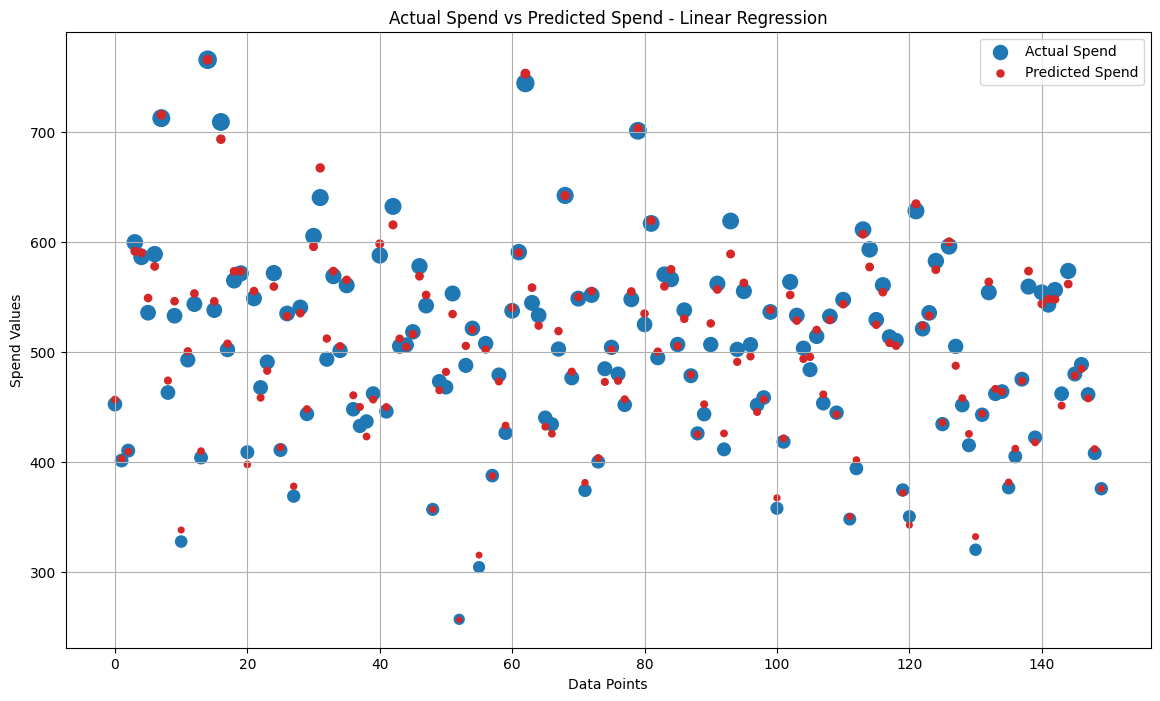

In [17]:
x = range(len(y_test))
y1 = y_test.values
y2 = predictions

f, ax = plt.subplots(figsize=(14, 8))
plt.scatter(x, y1, label='Actual Spend', c='tab:blue', s=y1/5)
plt.scatter(x, y2, label='Predicted Spend', c='tab:red', s=y2/20)

plt.title("Actual Spend vs Predicted Spend - Linear Regression")
plt.ylabel("Spend Values")
plt.xlabel("Data Points")
ax.grid(True)
plt.legend()
plt.show()

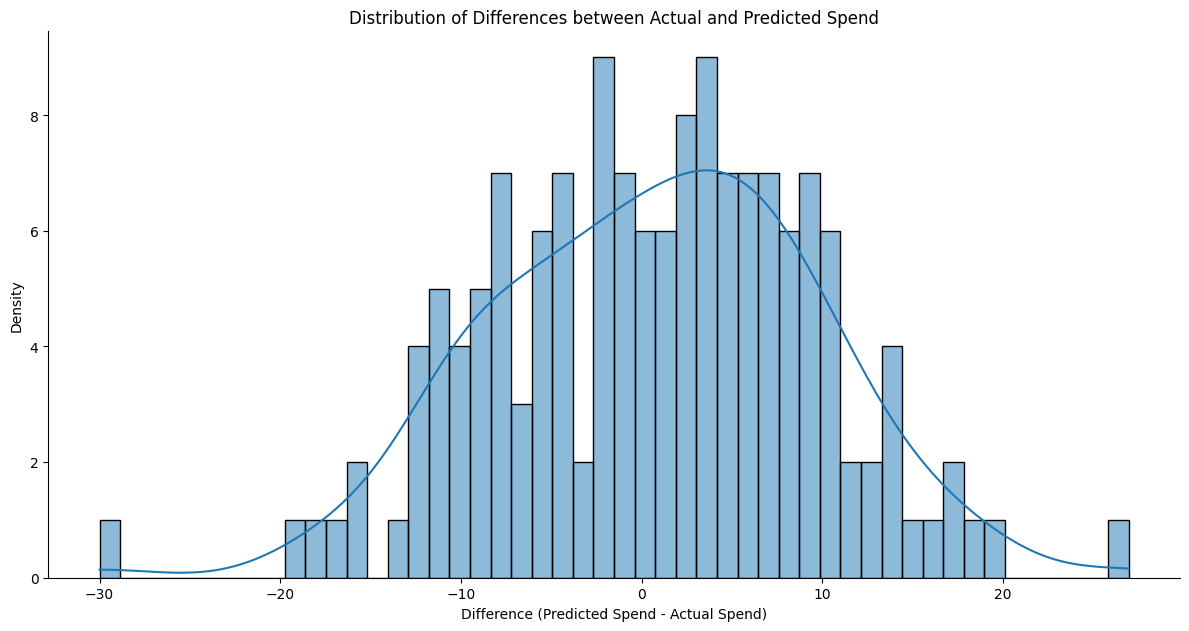

In [18]:
difference = y2 - y1

sns.displot(difference, bins=50, kde=True, legend=True, height=6, aspect=2)
plt.title("Distribution of Differences between Actual and Predicted Spend")
plt.xlabel("Difference (Predicted Spend - Actual Spend)")
plt.ylabel("Density")
plt.show()

In [19]:
coefficients = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficient']).round(2)

# Display the coefficients
print("Coefficients from the fitted model:")
print(coefficients)

Coefficients from the fitted model:
                      Coefficient
AVG. SESSION LENGTH         25.98
TIME ON APP                 38.59
TIME ON WEBSITE              0.19
LENGTH OF MEMBERSHIP        61.28
